In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_shufflenetv2_ssdlayers_light_relu6_se import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [5]:
import tensorflow as tf

run_meta = tf.RunMetadata()
with tf.Session(graph=tf.Graph()) as sess:
    K.set_session(sess)
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                input_tensor=tf.placeholder('float32', shape=(1,300,300,3)),
                mode='inference',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

In [6]:
# Factor 1.5
print("{:,} --- {:,}".format(flops.total_float_ops/2, params.total_parameters))

596,843,577.5 --- 5,384,276


## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 247.10it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv18_mbox_conf').output_shape[1:3],
                   model.get_layer('conv19_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv20_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv21_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv22_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [9]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.001
    elif epoch < 70:
        return 0.0001
    else:
        return 0.00001

In [9]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=1.5,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/shufflenetv2_ssdlayers_light/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2268, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 121s 604ms/step - loss: 64.6083 - val_loss: 2938.7871


/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:197: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:198: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-3,-1]] *= img_height # Convert ymin, ymax back to absolute coordinates


Number of images: 1025
Presicion: 0.0616
Recall: 0.3846
F1 score: 0.1062
F1 score: 0.10622778988844349
Improve F1 score from -inf to 0.10622778988844349
Epoch 2/100
200/200 [==============================] - 105s 525ms/step - loss: 5.3605 - val_loss: 151.3592
Number of images: 1025
Presicion: 0.0532
Recall: 0.3534
F1 score: 0.0924
F1 score: 0.09242071923293856
Epoch 3/100
200/200 [==============================] - 107s 536ms/step - loss: 5.1341 - val_loss: 11624.4445


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: invalid value encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box


Number of images: 1025
Presicion: 0.0445
Recall: 0.2783
F1 score: 0.0767
F1 score: 0.07671263366681555
Epoch 4/100
200/200 [==============================] - 109s 546ms/step - loss: 5.1164 - val_loss: 455495.2609
Number of images: 1025
Presicion: 0.0506
Recall: 0.3413
F1 score: 0.0881
F1 score: 0.08813578114300614
Epoch 5/100
200/200 [==============================] - 111s 554ms/step - loss: 5.1141 - val_loss: 204602.5519
Number of images: 1025
Presicion: 0.0442
Recall: 0.3488
F1 score: 0.0784
F1 score: 0.07841037625269713
Epoch 6/100
200/200 [==============================] - 108s 541ms/step - loss: 5.0835 - val_loss: 1605419.8031


/home/aldo/Documents/ssd/extra_files/helper.py:229: RuntimeWarning: invalid value encountered in double_scalars
  xB = min(boxA[2] + boxA[0], boxB[2] + boxB[0])
/home/aldo/Documents/ssd/extra_files/helper.py:230: RuntimeWarning: invalid value encountered in double_scalars
  yB = min(boxA[3] + boxA[1], boxB[3] + boxB[1])


Number of images: 1025
Presicion: 0.0457
Recall: 0.3332
F1 score: 0.0804
F1 score: 0.08036217758399411
Epoch 7/100
200/200 [==============================] - 111s 555ms/step - loss: 5.0817 - val_loss: 318992.9477
Number of images: 1025
Presicion: 0.0388
Recall: 0.3248
F1 score: 0.0693
F1 score: 0.06926631836745936
Epoch 8/100
200/200 [==============================] - 110s 552ms/step - loss: 5.0624 - val_loss: 148025.2208
Number of images: 1025
Presicion: 0.0482
Recall: 0.2777
F1 score: 0.0822
F1 score: 0.08216195541977908
Epoch 9/100
200/200 [==============================] - 101s 507ms/step - loss: 5.0836 - val_loss: 892001.5469
Number of images: 1025
Presicion: 0.0339
Recall: 0.291
F1 score: 0.0608
F1 score: 0.060756889272466
Epoch 10/100
200/200 [==============================] - 103s 515ms/step - loss: 5.0742 - val_loss: 4532101.1540
Number of images: 1025
Presicion: 0.044
Recall: 0.3564
F1 score: 0.0783
F1 score: 0.07832756154456214
Epoch 11/100
200/200 [=========================

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: overflow encountered in multiply
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:381: RuntimeWarning: invalid value encountered in subtract
  union_areas = boxes1_areas + boxes2_areas - intersection_areas
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: overflow encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]
/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: overflow encountered in subtract
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d

Number of images: 1025
Presicion: 0.0506
Recall: 0.3772
F1 score: 0.0893
F1 score: 0.08927050504670843
Epoch 42/100
200/200 [==============================] - 101s 505ms/step - loss: 4.9571 - val_loss: 212509.1656
Number of images: 1025
Presicion: 0.0512
Recall: 0.4004
F1 score: 0.0907
F1 score: 0.09074398222966927
Epoch 43/100
200/200 [==============================] - 102s 509ms/step - loss: 4.9491 - val_loss: 324023.8423
Number of images: 1025
Presicion: 0.0554
Recall: 0.4485
F1 score: 0.0986
F1 score: 0.0985889921264691
Epoch 44/100
200/200 [==============================] - 102s 509ms/step - loss: 4.9282 - val_loss: 720293.5738
Number of images: 1025
Presicion: 0.0503
Recall: 0.3973
F1 score: 0.0892
F1 score: 0.08923212940871235
Epoch 45/100
200/200 [==============================] - 103s 513ms/step - loss: 4.9351 - val_loss: 1148847.2686
Number of images: 1025
Presicion: 0.0414
Recall: 0.3902
F1 score: 0.0748
F1 score: 0.07484092780245476
Epoch 46/100
200/200 [===================

/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: invalid value encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]


Number of images: 1025
Presicion: 0.0492
Recall: 0.4071
F1 score: 0.0878
F1 score: 0.08777237379533895
Epoch 53/100
200/200 [==============================] - 101s 506ms/step - loss: 4.9276 - val_loss: 212014.8902
Number of images: 1025
Presicion: 0.0403
Recall: 0.3281
F1 score: 0.0718
F1 score: 0.07182482190143637
Epoch 54/100
200/200 [==============================] - 101s 506ms/step - loss: 4.9022 - val_loss: 202192.2020
Number of images: 1025
Presicion: 0.0552
Recall: 0.4389
F1 score: 0.0981
F1 score: 0.09808121899770027
Epoch 55/100
200/200 [==============================] - 103s 516ms/step - loss: 4.9297 - val_loss: 256244.8413


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: invalid value encountered in multiply
  boxes2_areas = (boxes2[:,xmax] - boxes2[:,xmin] + d) * (boxes2[:,ymax] - boxes2[:,ymin] + d)
/home/aldo/Documents/ssd/extra_files/helper.py:237: RuntimeWarning: invalid value encountered in double_scalars
  boxAArea = boxA[2] * boxA[3]
/home/aldo/Documents/ssd/extra_files/helper.py:238: RuntimeWarning: invalid value encountered in double_scalars
  boxBArea = boxB[2] * boxB[3]


Number of images: 1025
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 0.0
Epoch 56/100
200/200 [==============================] - 103s 513ms/step - loss: 4.8889 - val_loss: 200514.2929
Number of images: 1025
Presicion: 0.0496
Recall: 0.4064
F1 score: 0.0885
F1 score: 0.08845234477323324
Epoch 57/100
200/200 [==============================] - 101s 507ms/step - loss: 4.8510 - val_loss: 348008.4475
Number of images: 1025
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 0.0
Epoch 58/100
200/200 [==============================] - 102s 512ms/step - loss: 4.8706 - val_loss: 482616.2497
Number of images: 1025
Presicion: 0.0244
Recall: 0.3072
F1 score: 0.0452
F1 score: 0.04523303915210239
Epoch 59/100
200/200 [==============================] - 102s 508ms/step - loss: 4.8819 - val_loss: 1197973.7290
Number of images: 1025
Presicion: 0.0537
Recall: 0.406
F1 score: 0.0948
F1 score: 0.09480823197886153
Epoch 60/100
200/200 [==============================] - 102s 511ms/step - loss: 4.8495 - va

200/200 [==============================] - 104s 520ms/step - loss: 4.1591 - val_loss: 4.1966
Number of images: 1025
Presicion: 0.0532
Recall: 0.5607
F1 score: 0.0972
F1 score: 0.09722670202465593
Epoch 34/100
200/200 [==============================] - 103s 516ms/step - loss: 4.0970 - val_loss: 4.1570
Number of images: 1025
Presicion: 0.0441
Recall: 0.56
F1 score: 0.0818
F1 score: 0.08183408466888017
Epoch 35/100
200/200 [==============================] - 104s 521ms/step - loss: 4.1131 - val_loss: 4.1518
Number of images: 1025
Presicion: 0.0549
Recall: 0.5626
F1 score: 0.1001
F1 score: 0.10011686234469329
Epoch 36/100
200/200 [==============================] - 106s 528ms/step - loss: 4.0899 - val_loss: 4.2926
Number of images: 1025
Presicion: 0.0449
Recall: 0.5529
F1 score: 0.083
F1 score: 0.08301280181378135
Epoch 37/100
200/200 [==============================] - 104s 518ms/step - loss: 4.0493 - val_loss: 4.1926
Number of images: 1025
Presicion: 0.0467
Recall: 0.5646
F1 score: 0.0863
F

200/200 [==============================] - 104s 520ms/step - loss: 3.7351 - val_loss: 3.8646
Number of images: 1025
Presicion: 0.2987
Recall: 0.4399
F1 score: 0.3558
F1 score: 0.3557718489379082
Epoch 72/100
200/200 [==============================] - 105s 526ms/step - loss: 3.7473 - val_loss: 3.8024
Number of images: 1025
Presicion: 0.1649
Recall: 0.5168
F1 score: 0.25
F1 score: 0.2500323759974356
Epoch 73/100
200/200 [==============================] - 103s 516ms/step - loss: 3.7429 - val_loss: 3.7882
Number of images: 1025
Presicion: 0.3648
Recall: 0.4399
F1 score: 0.3989
F1 score: 0.3988535769468242
Improve F1 score from 0.3787672105392568 to 0.3988535769468242
Epoch 74/100
200/200 [==============================] - 105s 523ms/step - loss: 3.7291 - val_loss: 3.8273
Number of images: 1025
Presicion: 0.3733
Recall: 0.4231
F1 score: 0.3966
F1 score: 0.396635771526309
Epoch 75/100
200/200 [==============================] - 105s 525ms/step - loss: 3.7426 - val_loss: 3.8548
Number of image

200/200 [==============================] - 104s 522ms/step - loss: 5.3019 - val_loss: 5.1790
Number of images: 1025
Presicion: 0.098
Recall: 0.4322
F1 score: 0.1598
F1 score: 0.159800903201373
Epoch 8/100
200/200 [==============================] - 104s 522ms/step - loss: 5.2173 - val_loss: 5.1310
Number of images: 1025
Presicion: 0.0975
Recall: 0.4437
F1 score: 0.1599
F1 score: 0.1598523282523852
Epoch 9/100
200/200 [==============================] - 104s 520ms/step - loss: 5.1534 - val_loss: 5.0746
Number of images: 1025
Presicion: 0.0822
Recall: 0.4536
F1 score: 0.1392
F1 score: 0.1392418198409014
Epoch 10/100
200/200 [==============================] - 105s 523ms/step - loss: 5.1419 - val_loss: 5.0415
Number of images: 1025
Presicion: 0.0752
Recall: 0.4679
F1 score: 0.1296
F1 score: 0.1296438588441674
Epoch 11/100
200/200 [==============================] - 105s 525ms/step - loss: 5.0566 - val_loss: 4.9744
Number of images: 1025
Presicion: 0.0763
Recall: 0.4759
F1 score: 0.1315
F1 sco

Number of images: 1025
Presicion: 0.0492
Recall: 0.5374
F1 score: 0.0902
F1 score: 0.09020613258594687
Epoch 47/100
200/200 [==============================] - 104s 520ms/step - loss: 4.3412 - val_loss: 4.3746
Number of images: 1025
Presicion: 0.0517
Recall: 0.5385
F1 score: 0.0943
F1 score: 0.09432301615778714
Epoch 48/100
200/200 [==============================] - 104s 520ms/step - loss: 4.3207 - val_loss: 4.3541
Number of images: 1025
Presicion: 0.0503
Recall: 0.5436
F1 score: 0.092
F1 score: 0.09202673519392467
Epoch 49/100
200/200 [==============================] - 105s 526ms/step - loss: 4.3537 - val_loss: 4.3411
Number of images: 1025
Presicion: 0.0576
Recall: 0.5533
F1 score: 0.1044
F1 score: 0.10439610115598467
Epoch 50/100
200/200 [==============================] - 103s 517ms/step - loss: 4.2856 - val_loss: 4.3789
Number of images: 1025
Presicion: 0.052
Recall: 0.5452
F1 score: 0.0949
F1 score: 0.0949245964789606
Epoch 51/100
200/200 [==============================] - 105s 525

200/200 [==============================] - 104s 521ms/step - loss: 4.0502 - val_loss: 4.1014
Number of images: 1025
Presicion: 0.0553
Recall: 0.5692
F1 score: 0.1007
F1 score: 0.10074573589699563
Epoch 87/100
200/200 [==============================] - 102s 512ms/step - loss: 4.0650 - val_loss: 4.1092
Number of images: 1025
Presicion: 0.0494
Recall: 0.5687
F1 score: 0.0909
F1 score: 0.09094174396035369
Epoch 88/100
200/200 [==============================] - 103s 514ms/step - loss: 4.0915 - val_loss: 4.1472
Number of images: 1025
Presicion: 0.0479
Recall: 0.5653
F1 score: 0.0883
F1 score: 0.08827532458001235
Epoch 89/100
200/200 [==============================] - 105s 525ms/step - loss: 4.0427 - val_loss: 4.1043
Number of images: 1025
Presicion: 0.0705
Recall: 0.5694
F1 score: 0.1255
F1 score: 0.12554015331937554
Epoch 90/100
200/200 [==============================] - 105s 524ms/step - loss: 4.0130 - val_loss: 4.0960
Number of images: 1025
Presicion: 0.0485
Recall: 0.571
F1 score: 0.0895

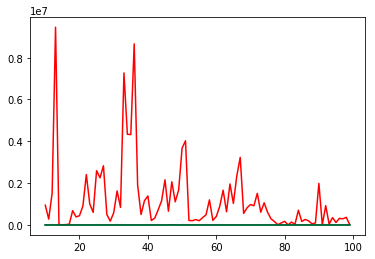

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

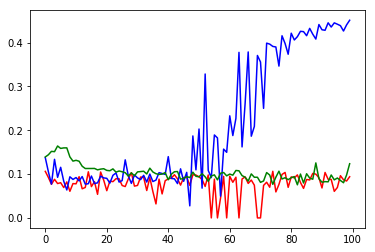

In [11]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [10]:
scale_factors = [1.5]

for factor in scale_factors:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH FACTOR:', factor)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                scale_factor=factor,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/shufflenet_v2_ssdlayers_light_relu6_se_factor_' + 
                           str(factor) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/shufflenet_v2_ssdlayers_light_relu6_se_factor_' + str(factor) + '.h5')

TRAINING MODEL WITH FACTOR: 1.5
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 572s 572ms/step - loss: 5.0769
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 557s 557ms/step - loss: 4.5210
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 4.3315
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 543s 543ms/step - loss: 4.2216
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 543s 543ms/step - loss: 4.1740
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 4.0438
Epoch 7/80

Epoch 00007: LearningRateS

1000/1000 [==============================] - 545s 545ms/step - loss: 3.0109
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 556s 556ms/step - loss: 3.0030
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 550s 550ms/step - loss: 3.0164
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 543s 543ms/step - loss: 2.9890
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 3.0030
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 547s 547ms/step - loss: 2.9777
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 548s 548ms/step - l